In [1]:
import sys
sys.version

import exoplanet
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
from astropy import units as u
from astropy.constants import M_earth, M_sun
from simulate_data import *
from model_data import *

import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)



WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


exoplanet.__version__ = '0.5.1'


In [163]:
T_subtract = 2454000
# orbital parameters from https://www.princeton.edu/~willman/planetary_systems/Sol/
# BJD determined by converting values above using https://ssd.jpl.nasa.gov/tc.cgi#top

P_earth = 365.256
e_earth = 0.0167
Tper_earth= 2454115.5208333 - T_subtract
omega_earth = np.radians(102.9)
Omega_earth = np.radians(0.0)
inclination_earth = np.radians(70.0)
m_earth = 1*3.00273e-6 #units m_sun



P_jup = 4327.631
e_jup = 0.0484
Tper_jup = 2455633.7215278 - T_subtract
omega_jup = np.radians(274.3) - 2*np.pi
Omega_jup = np.radians(100.4)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83*3.00273e-6 #units m_sun


m_sun = 333030 #earth masses


orbit_params_earth = [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, inclination_jup, m_jup]


orbit_params = [orbit_params_earth, orbit_params_jup]

times_observed_astrometry = []
t_0 = int(Tper_earth)
for ii in range(t_0, t_0+1000):
    if ii % 100 == 0:
        times_observed_astrometry.append(ii)

t_1 =  times_observed_astrometry[-1]+1800
for ii in range(t_1, t_1+1000):
    if ii % 100 == 0:
        times_observed_astrometry.append(ii)      
        
times_observed_rv = []
t_0 = int(Tper_earth)
add_data = True
for ii in range(t_0, t_0+3600):
    
    if ii % 180 == 0:
        if add_data:
            add_data = False
        else:
            add_data = True
        
    if add_data:
        times_observed_rv.append(ii)
        

n_planets = 2

sigma_rv = 0.3

sigma_theta = 0.001
sigma_rho = 0.00001
parallax = 0.1



times, rv_results, theta_results, rho_results = simulate_data(
    n_planets, 
    sigma_rv, 
    sigma_theta,
    sigma_rho,
    parallax,
    orbit_params,
    times_observed_rv = times_observed_rv,
    times_observed_astrometry = times_observed_astrometry
    )


[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
[rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
[theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
[rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = times, rv_results, theta_results, rho_results



In [164]:
x_rv = np.array(times_observed_rv)
y_rv = rv_sim_sum
y_rv_err = np.full(np.shape(y_rv), sigma_rv)

x_astrometry = np.array(times_observed_astrometry)
theta_data = theta_sim_sum
theta_err = np.full(np.shape(theta_data), sigma_theta)
rho_data = rho_sim_sum
rho_err = np.full(np.shape(rho_data), sigma_rho)


# make a fine grid that spans the observation window for plotting purposes
t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

# for predicted orbits
t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)





finding RV model solutions


optimizing logp for variables: [logK, ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -358770.9734257385 -> -1619.9543256579057
optimizing logp for variables: [logK, ecs, tperi]


message: Desired error not necessarily achieved due to precision loss.
logp: -1619.9543256579057 -> -1049.7239979891017
optimizing logp for variables: [logs, ecs, logK, logP, tperi]


message: Optimization terminated successfully.
logp: -1049.7239979891017 -> -1049.4500872936578


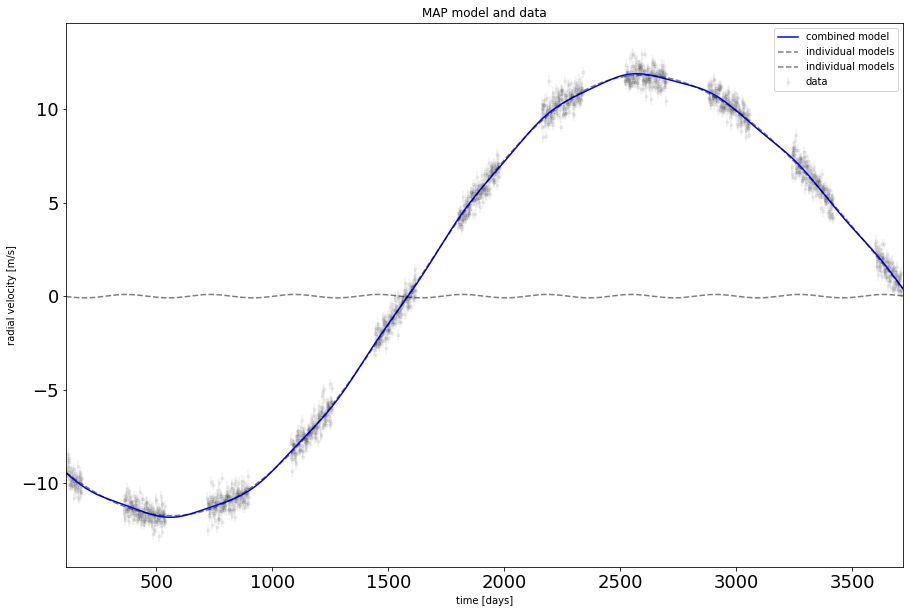

In [165]:

periods_guess = [360, 4330]
Ks_guess = xo.estimate_semi_amplitude(periods_guess, x_rv, y_rv, y_rv_err)


print("finding RV model solutions")
rv_map_soln = model_rv(periods_guess, Ks_guess, x_rv, y_rv, y_rv_err)

fig, ax = plt.subplots(1, figsize = [15,10])

ax.errorbar(x_rv, y_rv, yerr=y_rv_err, fmt=".k", alpha = 0.05, label='data', zorder=1)
ax.plot(t_rv, rv_map_soln["rv_model_pred"], "b", label="combined model", zorder=2)
ax.plot(t_rv, rv_map_soln["vrad_pred"], "--k", alpha=0.5, label="individual models")


ax.legend(fontsize=10)
ax.set_xlim(t_rv.min(), t_rv.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")
ax.set_title("MAP model and data")

plt.show()



In [166]:
print("finding joint model solutions")
parallax = 0.1 # arcsec
model, map_soln = model_both(rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, 
                             rho_data, rho_err, theta_data, theta_err, parallax)



finding joint model solutions
[ 363.0258694  4332.70463407]
[ 0.09120939 11.79307718]
[2476.81169576 1630.52170972]
[0.02208424 0.04901839]
[-1.23796474 -1.49745928]


optimizing logp for variables: [sqrtm_sini, sqrtm_cosi]


message: Desired error not necessarily achieved due to precision loss.
logp: -555381966.3365339 -> -24784951.265521232
optimizing logp for variables: [phase]


message: Desired error not necessarily achieved due to precision loss.
logp: -24784951.265521232 -> -20146650.81747931
optimizing logp for variables: [ecs, Omega_plus, Omega_minus]


message: Desired error not necessarily achieved due to precision loss.
logp: -20146650.81747931 -> -2404171.0880927215
optimizing logp for variables: [phase, sqrtm_sini, sqrtm_cosi, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -2404171.0880927215 -> -16103.977994970359
optimizing logp for variables: [log_rv, log_theta_s, log_rho_s, sqrtm_cosi, sqrtm_sini, phase, Omega_minus, Omega_plus, ecs, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: -16103.977994970253 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


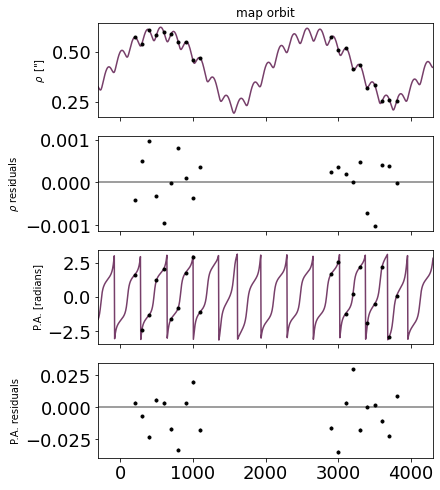

In [167]:


ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(x_astrometry, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_model_pred"], color="#773f6a")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
	x_astrometry, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_model_pred"], color="#773f6a")
ax[2].errorbar(x_astrometry, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
	x_astrometry, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

plt.show()



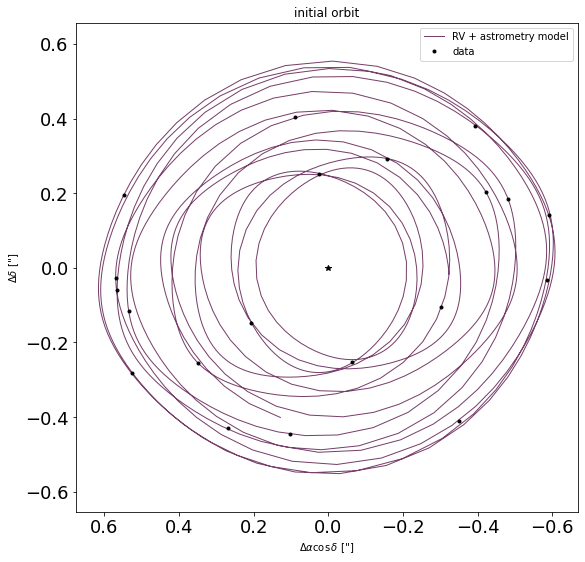

In [168]:


fig, ax = plt.subplots(1, figsize = [9,9])

xs = map_soln["rho_model_pred"] * np.cos(map_soln["theta_model_pred"])  # X is north
ys = map_soln["rho_model_pred"] * np.sin(map_soln["theta_model_pred"])  # Y is east
ax.plot(ys, xs, color="#773f6a", lw=1, label = "RV + astrometry model")


# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k", label = "data")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend()
plt.show()



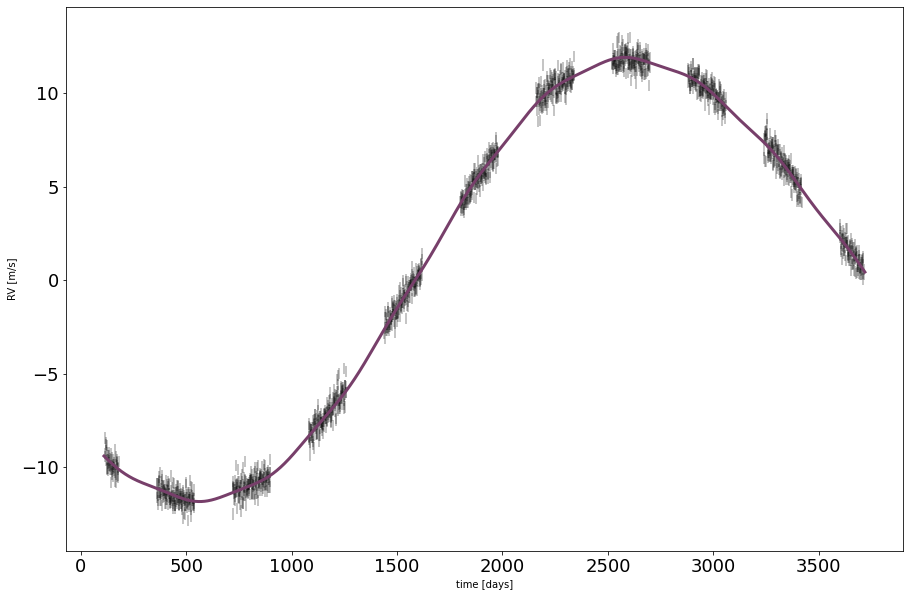

In [169]:
plt.figure(figsize=[15,10])
plt.plot(t_rv, map_soln["rv_model_pred"],color="#773f6a", lw=3)
plt.errorbar(x_rv, y_rv, yerr= y_rv_err, color='k', alpha=0.3, linestyle = '')
plt.xlabel("time [days]")
plt.ylabel("RV [m/s]")
plt.show()



In [198]:
from astropy.coordinates import SkyCoord

# initialize the orbit
orbit = xo.orbits.KeplerianOrbit(
    t_periastron=[Tper_earth, Tper_jup], period=[P_earth, P_jup], ecc=[e_earth, e_jup], 
    omega=[omega_earth, omega_jup], m_planet = [m_earth, m_jup], 
    Omega = [Omega_earth, Omega_jup], incl = [inclination_earth, inclination_jup])

# determine and print the star position at desired times
pos = theano.function([], orbit.get_star_position(x_astrometry))()
pos = tt.sum(pos, axis=-1)

x,y,z = pos.eval()
x,y,z = x,y,z*u.Rsun
x,y,z = x,y,z.to(u.au)

print(x,y,z)


c = SkyCoord(x=x, y=y, z=z, unit='au', representation_type='cartesian')
c.representation_type = 'unitspherical'
print("")
print(c)
print(c[:,])

[ 3.42886449e-04  5.57052859e-02  1.09589451e-01  1.59887830e-01
  2.07669248e-01  2.52163213e-01  2.90130015e-01  3.20898141e-01
  3.45817449e-01  3.63193475e-01 -3.20124986e-01 -3.51123531e-01
 -3.75806180e-01 -3.91761102e-01 -4.00056772e-01 -4.02273996e-01
 -3.96728049e-01 -3.82464158e-01 -3.61836305e-01 -3.35800957e-01] [-0.96544281 -1.01625249 -1.04638225 -1.05550394 -1.04323633 -1.00861981
 -0.9519323  -0.87471985 -0.77806636 -0.66313014  0.93869401  0.86488918
  0.77352945  0.66701428  0.54823456  0.41910288  0.28164856  0.13915293
 -0.00545822 -0.15026144] [-0.00238212 -0.00176768 -0.00112426 -0.00045565  0.00022785  0.00090229
  0.00155302  0.00217496  0.00275055  0.00325702 -0.00200443 -0.002608
 -0.00315416 -0.00363745 -0.00405751 -0.00440097 -0.00465595 -0.00482702
 -0.0049151  -0.00490955] AU

<SkyCoord (ICRS): (ra, dec) in deg
    [(270.02034916, -0.1413706 ), (273.13749483, -0.09951118),
     (275.9788909 , -0.0612254 ), (278.61368426, -0.0244552 ),
     (281.25827513,  

In [171]:
def DEC(z):
    return np.arcsin(z)

def RA(y, DEC):
    sin_ra = y/np.cos(DEC)
    print('here')
    if sin_ra.any() < -np.pi/2:
        print(hi)
        sin_ra += 2*np.pi
    print(sin_ra)
    print(np.arcsin(sin_ra))
    return np.arcsin(sin_ra)

In [172]:
dec = DEC(z)
ra = RA(y, dec)

here
[-1.12411545 -1.09871974 -1.07836901 -1.0606072  -1.04449069 -1.02815749
 -1.00991029 -0.98961966 -0.96493991 -0.92903331  1.0402846   1.04461682
  1.05265821  1.07053344  1.12199922  1.29695966         nan         nan
         nan         nan]
[        nan         nan         nan         nan         nan         nan
         nan -1.42658575 -1.30521432 -1.1917915          nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]


<ipython-input-171-896eadc34450>:2: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(z)
<ipython-input-171-896eadc34450>:11: RuntimeWarning: invalid value encountered in arcsin
  print(np.arcsin(sin_ra))
<ipython-input-171-896eadc34450>:12: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(sin_ra)


In [173]:
print(dec)
print(ra)

[-0.5377825  -0.38991226 -0.24417198 -0.09813766  0.04901369  0.19525935
  0.34049057  0.48667036  0.6328645   0.7759084  -0.44562033 -0.59535629
 -0.74537386 -0.89813831 -1.06028557 -1.24174798         nan         nan
         nan         nan]
[        nan         nan         nan         nan         nan         nan
         nan -1.42658575 -1.30521432 -1.1917915          nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan]


In [181]:
print(x,y,z)

[ 3.42886449e-04  5.57052859e-02  1.09589451e-01  1.59887830e-01
  2.07669248e-01  2.52163213e-01  2.90130015e-01  3.20898141e-01
  3.45817449e-01  3.63193475e-01 -3.20124986e-01 -3.51123531e-01
 -3.75806180e-01 -3.91761102e-01 -4.00056772e-01 -4.02273996e-01
 -3.96728049e-01 -3.82464158e-01 -3.61836305e-01 -3.35800957e-01] [-0.96544281 -1.01625249 -1.04638225 -1.05550394 -1.04323633 -1.00861981
 -0.9519323  -0.87471985 -0.77806636 -0.66313014  0.93869401  0.86488918
  0.77352945  0.66701428  0.54823456  0.41910288  0.28164856  0.13915293
 -0.00545822 -0.15026144] [-0.00238212 -0.00176768 -0.00112426 -0.00045565  0.00022785  0.00090229
  0.00155302  0.00217496  0.00275055  0.00325702 -0.00200443 -0.002608
 -0.00315416 -0.00363745 -0.00405751 -0.00440097 -0.00465595 -0.00482702
 -0.0049151  -0.00490955] solRad2
